# XY-calibration (F4)

In [1]:
cd ..

/Users/Vincent/Github/FireBallPipe



| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  |                             |
| 2.5  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line   |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [42]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## initialization from last xy calib
---------------------------------

In [36]:
# prerequisites:
Field = "F4"
# previous_xy_mapping = 'Notebook/Files/Guider2UV_%s_nogamma.new.pkl'%(Field)
previous_xy_mapping = "Calibration/Mappings/2022/XY/F1_prep1_XY_220715.pkl"
# mask_det_map_file = "Calibration/Mappings/2022/mapping-mask-det-w-2022-5-%s_center.pkl"%(Field)
mask_det_map_file = "Calibration/Mappings/2022/mapping_new_center/mapping-mask-det-w-2022-5-%s_-20.pkl"%(Field)
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
# mapping_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/%s/%s_2022_6_-82.fits"%(Field,Field)
# new_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/%s/%s_2022_6_-106.fits"%(Field,Field)
# encoder gains 2018:
# CEg = 1.02928
# Elg = 1.00379
# encoder gains 2022:
CEg = 1.0187
Elg = 1.0090
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09283 ''/inc and Ce is 0.01019 ''/inc


In [46]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)

G2UV.FieldP.center = (36.9049*u.deg, 0.65245*u.deg)
# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.FieldP = LocalScienceMaskProjector(center=(36.9049*u.deg, 0.65245*u.deg), rotation=0.0*u.arcmin, gamma=1)
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)
# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)


# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    (0.18640794, -0.08284778)>
FOV center pixel position in guider [array(1378.69397987), array(218.86229257)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.392728151  36.4185638082  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024551548564194  0.00024661678545423  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV cent

## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# # prerequisites:
# previous_xy_mapping = 'Notebook/Files/Guider2UV_F1_nogamma.new.pkl'
# mask_det_map_file = "Calibration/Mappings/2022/mapping-mask-det-w-2022-5-F1.pkl"
# target_filename = 'Calibration/Targets/2022/targets_F1.txt'
# mapping_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/F1/F1_2022_6_-82.fits"
# new_diffuse_image = "/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/all_diffuse_illumination/FocusEvolution/F1/F1_2022_6_-106.fits"

# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 
# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# # print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

In [6]:
# data1 = fits.open(mapping_diffuse_image)[0].data[1404:1500,1925:2080]
# data2 = fits.open(new_diffuse_image)[0].data[1404:1500,1925:2080]
# data1 = (data1-data1.min()) / (data1-data1.min()).ptp()
# data2 = (data2-data2.min()) / (data2-data2.min()).ptp()
# fig, axes = heatmap_slicer(
#     np.arange(data2.shape[1]),
#     np.arange(data2.shape[0]),
#     (data1, data2),
#     slices="both",
#     figsize = (8,8),
#     heatmap_names=("Old diffuse image", "Map based diffuse"),
#     labels=("Some wild X variable", "Y axis"),
#     interaction_type="click")
# plt.tight_layout()
# plt.show()



Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [7]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([2,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1)
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

GC - 46 - 51 - 19 - 8 - 12 - 10 - 38 - 43

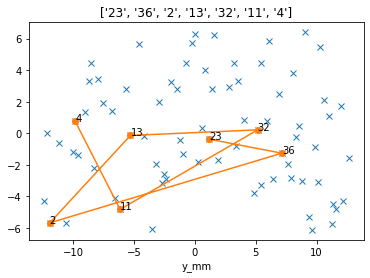

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
23,1.149408,-0.37309,36.931808,0.643882,-506.0812419404365,74.80799999999968,511.5803556705188
36,7.136533,-1.264856,37.072395,0.623102,1613.8349615117118,375.41520000000037,1656.9248188703518
2,-11.936418,-5.681635,36.624081,0.51882,-562.6281328234214,-463.19400000000013,728.7654612290361
13,-5.303522,-0.138687,36.780373,0.647485,-883.6139752233256,-30.376800000000202,884.135966460028
32,5.155472,0.21635,37.025837,0.655923,955.8561607255427,420.24240000000003,1044.1573994157848
11,-6.155668,-4.825373,36.760304,0.539189,313.1789319515288,-475.4807999999997,569.3531721058029
4,-9.854999,0.771802,36.673306,0.671267,0.0,0.0,0.0
4,-9.854999,0.771802,36.673306,0.671267,-313.1713057579012,475.4807999999997,569.3489772703105
11,-6.155668,-4.825373,36.760304,0.539189,-955.8764723083938,-420.24240000000003,1044.1759933414


In [8]:
slits = ['46', '51', '14', '8', '12', '16', '38', '44']  #2018
slits = ['46', '51', '19', '8', '12', '10', '38', '43']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
slits = ['46', "51", '35', '12','38']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
# slits = ['4',  '42', '12','38']  # 2022 because 44 and 14 are not visible in 213.9. need to bee thought
# mask = F1.to_pandas()['Internal-count'].isin(slits)
slits =['4', '38', '24', '2', '6', '37', '11',"25"] 
slits =['23', '36', '2', '13', '32', '11',"4"] #add 27
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure()
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = [0] + list((slit_path[ra][1:] - slit_path[ra][:-1])*np.cos(slit_path[dec][:-1]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path[dec][1:] - slit_path[dec][:-1])) 
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = False)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
print(moves.sum(axis=0)[0])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()
moves 


slit position in mm on mask: [ 1.149408 -0.37309 ]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-11.936418  -5.681635]
slit position in mm on mask: [-5.303522 -0.138687]
slit position in mm on mask: [5.155472 0.21635 ]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-9.854999  0.771802]

targets local coords in siderostat local frame:
EL: 318.4 arcsec ; CE: 192.4 arcsec
EL: 280.6 arcsec ; CE: 440.4 arcsec
EL: 92.6 arcsec ; CE: -350.4 arcsec
EL: 328.4 arcsec ; CE: -74.7 arcsec
EL: 343.5 arcsec ; CE: 358.3 arcsec
EL: 129.3 arcsec ; CE: -110.1 arcsec
EL: 367.1 arcsec ; CE: -263.5 arcsec

siderostat moves sequence: 
367.0642272665182
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,318.436356,192.447995,True,318.436356,192.447995
1,-37.880946,247.983081,True,280.555410,440.431076
2,-188.002065,-790.783003,True,92.553346,-350.351928
3,235.826907,275.680039,True,328.380253,-74.671888
4,15.070878,432.977500,True,343.451130,358.305611
5,-214.119468,-468.381421,True,129.331662,-110.075809
6,237.732565,-153.445835,True,367.064227,-263.521645


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [10]:
# print(len(slit_path))
slits_coord_obs_det = np.array([
[ 2003.28  ,	815.70],
[ 1946.4278  ,	366.6895],
[ 1655.4181  ,	1806.5215],
[ 2019.965  ,	1299.2635],
[ 2044.314  ,	516.54041],
[ 1707.477  ,	1366.6448],
[ 2085.6851,	1638.469]]) # np.ones((2,len(selected_slits))).T

# selected_slits["x_det_obs"] = slits_coord_obs_det[:,0]
# selected_slits["y_det_obs"] = slits_coord_obs_det[:,1]
# #TODO should add difference
# # slit_path
# # slit_path.write("/tmp/slit.csv",overwrite=True)
# slit_path = selected_slits
# slit_path
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

NameError: name 'obs_wave' is not defined

In [11]:
# # TODO create some quiver of the error
# plt.figure()
# plt.plot(F1["x_mm"],F1["y_mm"],"x")
# plt.plot(selected_slits["x_mm"],selected_slits["y_mm"],"-o")
# for s in selected_slits:
#     plt.text(s["x_mm"],s["y_mm"],s["Internal-count"])
# plt.quiver(slit_path["x_mm"],slit_path["y_mm"],slit_path["x_det_obs"],slit_path["y_det_obs"])
# plt.xlabel("x_mm")
# plt.xlabel("y_mm")
# plt.title(Field + " : %s"%(slits))
# plt.show()

In [18]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
# obs_wave = G2UV.mask_det_map.w[0]
try:
    obs_wave = G2UV.mask_det_map.w[0]
except (TypeError, AttributeError) as e:
    obs_wave = 0.2139
    # obs_wave = 0.20619 #0.2139
    # obs_wave = [0.20619, 0.2139, 0.2139, 0.2139, 0.2139, 0.2139, 0.2139, 0.2139]
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.2139


### look at siderostat frame hysteresis 

In [13]:
mid  = len(slits_coord_obs_det)//2
pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
# pair_diff
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(np.abs(pair_diff[:,0]),'*')
# ax0.plot(np.abs(pair_diff[:,0]),'-')
# ax0.set_title("El pair diff")
# ax0.set_ylabel("El arcsec")
# ax1.plot(np.abs(pair_diff[:,1]),'*')
# ax1.plot(np.abs(pair_diff[:,1]),'-')
# ax1.set_title("Ce pair diff")
# ax1.set_ylabel("Ce arcsec")
# fig.suptitle(Field + " : Hysteresis analysis")
# fig.tight_layout()

moves_sign  = np.sign(moves[2:mid+2])
pair_diff_signed = pair_diff * moves_sign
valid = np.arange(len(moves_sign))#[0,2,3,4]
fig, (ax0,ax1) = plt.subplots(1,2)
ax0.plot(pair_diff_signed[valid,0],'*-')
ax0.set_title("El pair diff")
ax0.set_ylabel("El arcsec")
ax1.plot(pair_diff_signed[valid,1],'*-')
ax1.set_title("Ce pair diff")
ax1.set_ylabel("Ce arcsec")
fig.suptitle("Hysteresis analysis")
fig.tight_layout()


UFuncTypeError: ufunc 'sign' did not contain a loop with signature matching types dtype('bool') -> dtype('bool')

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

In [14]:
slits_coord_obs_det

array([[2003.28   ,  815.7    ],
       [1946.4278 ,  366.6895 ],
       [1655.4181 , 1806.5215 ],
       [2019.965  , 1299.2635 ],
       [2044.314  ,  516.54041],
       [1707.477  , 1366.6448 ],
       [2085.6851 , 1638.469  ]])

In [87]:
slits_coord_valid[1:]

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.15645484, -0.25184828)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.0516134, 0.20033902)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1831249, 0.04269905)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.19152934, -0.20488711)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.07212324, 0.06294379)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (l

In [99]:
slits_coord_obs[1:]

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1563221, -0.25466199)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.05017838, 0.20327737)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1830106, 0.041714)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.19160946, -0.20621926)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.06999718, 0.06440552)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon

In [79]:
slits_coord_obs[1:]

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1563221, -0.25466199)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.05017838, 0.20327737)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1830106, 0.041714)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.19160946, -0.20621926)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.06999718, 0.06440552)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon

In [15]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.17282303, -0.14765249)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.15171089, -0.28499164)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.04709097, 0.15756409)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.17828962, 0.00111517)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.18662782, -0.23878934)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>):

Fitting rotation, translation and magnification
row_x, row_y =  [[ 0.15645484  0.25184828  1.          0.        ]
 [ 0.0516134  -0.20033902  1.          0.        ]
 [ 0.1831249  -0.04269905  1.          0.        ]
 [ 0.19152934  0.20488711  1.          0.        ]
 [ 0.07212324 -0.06294379  1.          0.        ]
 [ 0.20469744 -0.15068753  1.          0.        ]] [[-0.25184828  0.15645484  0.          1.        ]
 [ 0.20033902  0.0516134   0.          1.        ]
 [ 0.04269905  0.1831249   0.          1.        ]
 [-0.20488711  0.19152934  0.          1.        ]
 [ 0.06294379  0.07212324  0.          1.        ]
 [ 0.15068753  0.20469744  0.          1.        ]]
mat =  [[ 0.15645484  0.25184828  1.          0.        ]
 [ 0.0516134  -0.20033902  1.          0.        ]
 [ 0.1831249  -0.04269905  1.          0.        ]
 [ 0.19152934  0.20488711  1.          0.        ]
 [ 0.07212324 -0.06294379  1.          0.        ]
 [ 0.20469744 -0.15068753  1.          0.        ]
 [-0.2518

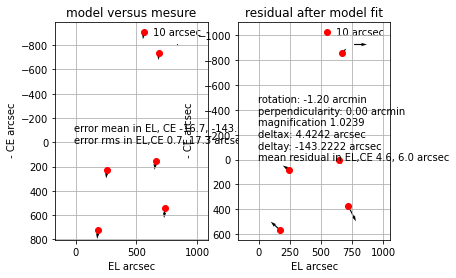

After updating:
    mask_rotation: -1.2035698095570653 arcmin
    FOV center in guider: 1398.9724434039827 x 365.8541326450214 pix = 691.4174248524289 arcsec x -162.38871866451066 arcsec arcsec
    mask_magnification correction: 1.0238857916369708  
    


In [19]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True)#, labels=slits_valid


### save corrected model for future use (eg redo the clalib on same field)

In [52]:
G2UVcor.save(filename="Calibration/Mappings/2022/XY/%s_XY_%s.pkl"%(Field,datetime.datetime.now().strftime("%y%m%d")))

Dumping to Calibration/Mappings/2022/XY/F4_XY_220715.pkl


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [91]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = False, CEg = CEg, Elg = Elg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves.to_clipboard()
moves

slit position in mm on mask: [ 1.149408 -0.37309 ]
slit position in mm on mask: [ 7.136533 -1.264856]
slit position in mm on mask: [-11.936418  -5.681635]
slit position in mm on mask: [-5.303522 -0.138687]
slit position in mm on mask: [5.155472 0.21635 ]
slit position in mm on mask: [-6.155668 -4.825373]
slit position in mm on mask: [-9.854999  0.771802]

targets local coords in siderostat local frame:
EL: 326.5 arcsec ; CE: 128.9 arcsec
EL: 287.8 arcsec ; CE: 385.4 arcsec
EL: 96.6 arcsec ; CE: -432.7 arcsec
EL: 336.7 arcsec ; CE: -147.4 arcsec
EL: 351.9 arcsec ; CE: 300.5 arcsec
EL: 134.0 arcsec ; CE: -184.1 arcsec
EL: 376.2 arcsec ; CE: -342.8 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image
0,326.482184,128.904401,1.0
1,-38.676171,256.529989,1.0
2,-191.209535,-818.146962,1.0
3,240.112226,285.279716,1.0
4,15.192852,447.929055,1.0
5,-217.930587,-484.625415,1.0
6,242.210247,-158.658760,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [64]:
slits_coord_obs

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1772047, -0.11182764)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1563221, -0.25466199)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.05017838, 0.20327737)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.1830106, 0.041714)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon, lat) in deg
     [(0.19160946, -0.20621926)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39272815, 36.41856381)>): (lon

Fitting rotation, translation and magnification
row_x, row_y =  [[ 0.15645484  0.25184828  1.          0.        ]
 [ 0.0516134  -0.20033902  1.          0.        ]
 [ 0.1831249  -0.04269905  1.          0.        ]
 [ 0.19152934  0.20488711  1.          0.        ]
 [ 0.07212324 -0.06294379  1.          0.        ]
 [ 0.20469744 -0.15068753  1.          0.        ]] [[-0.25184828  0.15645484  0.          1.        ]
 [ 0.20033902  0.0516134   0.          1.        ]
 [ 0.04269905  0.1831249   0.          1.        ]
 [-0.20488711  0.19152934  0.          1.        ]
 [ 0.06294379  0.07212324  0.          1.        ]
 [ 0.15068753  0.20469744  0.          1.        ]]
mat =  [[ 0.15645484  0.25184828  1.          0.        ]
 [ 0.0516134  -0.20033902  1.          0.        ]
 [ 0.1831249  -0.04269905  1.          0.        ]
 [ 0.19152934  0.20488711  1.          0.        ]
 [ 0.07212324 -0.06294379  1.          0.        ]
 [ 0.20469744 -0.15068753  1.          0.        ]
 [-0.2518

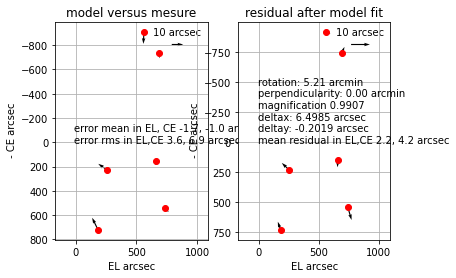

After updating:
    mask_rotation: 4.006674055644082 arcmin
    FOV center in guider: 1399.2818007707926 x 368.8364772982447 pix = 691.7252034485729 arcsec x -159.62717549633345 arcsec arcsec
    mask_magnification correction: 1.0143537780898824  
    


(<guider2UV.guider2UV.Guider2UV at 0x7fa668cbe8e0>,
 array([[ 5.97561564e-04, -1.75904721e-04],
        [-4.14011407e-04,  1.20755944e-03],
        [-7.86988226e-05, -1.04894607e-03],
        [ 4.12716103e-04,  9.21633355e-04],
        [-1.08775557e-03,  1.04111939e-03],
        [ 5.70188130e-04, -1.94546140e-03]]))

In [22]:
slits_coord_obs_det = np.array([
[2015.5591,  	931.45115  ],
[1958.5063  ,	467.6615  ],
[1665.4307  ,	1955.4355  ],
[2034.4282 ,	1432.4388  ],
[2057.2718 ,	620.85921  ],
[1715.4736 ,	1503.1555  ],
[2102.354,  	1784.8877  ]]) 

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True)#, labels=slits_valid





## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence 
gc - s8 - s25 - s31

In [69]:
F1_stars

,Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
0,1,36.737339,0.339020,-7.130249,-13.337500,<NA>,<NA>,13,122.151387,1298.132040
1,2,36.747639,0.670835,-6.691532,0.782461,<NA>,12,12,1458.077564,1219.460838
2,3,36.754892,0.533429,-6.383080,-5.064658,<NA>,13,12,919.452076,1212.485004
3,4,36.759354,0.693686,-6.193004,1.754827,<NA>,14,13,1543.722042,1169.992241
4,5,36.769798,0.659670,-5.748668,0.307307,<NA>,13,13,1412.002699,1135.629710
5,6,36.778383,0.429222,-5.383609,-9.499073,<NA>,<NA>,13,493.109220,1128.948828
6,7,36.779433,0.355071,-5.339015,-12.654508,<NA>,13,13,183.273122,1127.703808
7,8,36.783078,0.538763,-5.183698,-4.837709,<NA>,12,12,936.688022,1100.729074
8,9,36.798163,0.354144,-4.541975,-12.693978,<NA>,<NA>,12,176.840937,1051.713541
9,10,36.810875,0.552607,-4.000899,-4.248598,<NA>,<NA>,13,988.494557,989.198912


In [47]:
G2UVcor.FOV_center_guider_coord

<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.18182478, 0.00998363)]>

In [30]:
G2UVcor.FieldP.center = 36.9049, 0.65245
star_target_path = "Calibration/Targets/2022/GuidingStars/F4_guidingstars.fits"

F1_stars = Table.read(star_target_path, format='fits').to_pandas()

stars = [29, 34, 18, 14]# [8, 25, 31]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = False, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves
# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: 11189.5 arcsec ; CE: 8462.3 arcsec
EL: 11168.2 arcsec ; CE: 8526.8 arcsec
EL: 11422.7 arcsec ; CE: 8268.6 arcsec
EL: 11350.3 arcsec ; CE: 8250.7 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,11189.542520,8462.257219,1.0
1,-21.387270,64.499088,1.0
2,254.589031,-258.183802,1.0
3,-72.466416,-17.830610,1.0


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [20]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
8,32.1014,-5.786504,-3.751016,-4.191964,11,11,11,954.7166340246686,952.1343510310977
25,32.221491,-5.776507,1.333233,-3.766303,9,--,--,990.2173692400569,476.91827039575276
31,32.254526,-5.815258,2.731668,-5.415391,--,12,12,836.6074480025399,344.4301880821129
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------

In [29]:
G2UVcor.FOV_center_guider_coord = Guider2UV(filename='/Volumes/ExtremePro/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/F4_180904.pkl').FOV_center_guider_coord
0.18182478, 0.00998363

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39242605, 36.41307253)>): (lon, lat) in deg
    [(0.18182478, 0.00998363)]>
FOV center pixel position in guider [array([1361.55931784]), array([571.29095342])]


(0.18182478, 0.00998363)

In [26]:
G2UVcor.FOV_center_guider_coord

(0.18182478, 0.00998363)